# Entendimiento de los datos con PySpark - PIBcopia, divipolacopia

En esta parte se realizaron los pasos correspondientes con el entendimiento de los datos asociados a la primera entrega del proyecto

### Perfilamiento de datos

Configuración y Conexión de Datos

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import numpy as np

In [3]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [5]:
#Configuración de la sesión
#if spark:
#    spark.stop()
    
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [6]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
db_user = 'Estudiante_59_202314'
db_psswd = 'aabb1122'

PATH='./'

In [7]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

In [8]:
sql_pibcopia = 'ProyectoTransaccional.PIBCopia'
sql_divipolacopia = 'ProyectoTransaccional.divipolaCopia'

In [9]:
#Se cargan los dataframes desde la base de datos
pibcopia = obtener_dataframe_de_bd(db_connection_string, sql_pibcopia, db_user, db_psswd)
divipolacopia = obtener_dataframe_de_bd(db_connection_string, sql_divipolacopia, db_user, db_psswd)

1.1 Cantidad de registros y cantidad de columnas por tipo de dato

In [10]:
pibcopia.show(5) 
divipolacopia.show(5)

+-------------------------------+-------------+-------+--------+--------------------+--------------------+--------+--------+--------------------+--------+
|CÃ³digo Departamento (DIVIPOLA)|DEPARTAMENTOS|   2006|    2007|                2008|                2010|    2011|    2012|                2013|    2014|
+-------------------------------+-------------+-------+--------+--------------------+--------------------+--------+--------+--------------------+--------+
|                             41|         uila|6895658| 7441987|   8686536.103258422|    9548624.85406653|11113741|11400169|1.1967750469189592E7|12755711|
|                             18|     CaquetÃ¡|3575615| 4060678|   4519574.129383702|   5048396.606737779| 5516404| 6476778|    7161524.44383983| 7990249|
|                              8|   AtlÃ¡ntico|7194985| 8299825|   8858405.054387597|   9481200.322350295|10288314|11421539|1.2434114309437651E7|13681473|
|                             63|     QuindiÃ³|6350376| 6908084|  7449

En el primer dataframe de pibcopia encontramos datos asociados al PIB de cada departamento, esto asociando su codigo, nombre, y el valor en cada año.

En el segundo dataframe de divipolacopia encontramos datos asociados a los departamentos, con su codigo de departamento (ANM), codigo de municipio, codigo centro poblado, nombre de departamento, nombre de municipio, nombre de centro poblado, tipo de centro poblado, longitud, latitud, nombre distrito y municipio no municipalizada y nombre de area metropolitana.

In [13]:
print('pibcopia')
print((pibcopia.count(), len(pibcopia.columns)))

pibcopia
(27, 10)


Para este analisis nos compartieron un total de 27 datos asociados al PIB y tenemos 10 variables a revisar.

In [14]:
print('divipolacopia')
print((divipolacopia.count(), len(divipolacopia.columns)))

divipolacopia
(9508, 12)


Y por otro lado nos copartieron un total de 9508 datos asociados a divipola y tenemos 12 variables a revisar.

1.2 Significado de una fila

In [15]:
pibcopia.schema

StructType(List(StructField(CÃ³digo Departamento (DIVIPOLA),LongType,true),StructField(DEPARTAMENTOS,StringType,true),StructField(2006,LongType,true),StructField(2007,LongType,true),StructField(2008,DoubleType,true),StructField(2010,DoubleType,true),StructField(2011,LongType,true),StructField(2012,LongType,true),StructField(2013,DoubleType,true),StructField(2014,LongType,true)))

Encontramos en el schema valores de tipo Long, String, Double

Con estos analisis podemos concluir que una fila de la tabla de pibbopia representa un dato del PIB asociado a un departamento divido por cada año.

In [16]:
divipolacopia.schema

StructType(List(StructField(Código Departamento,IntegerType,true),StructField(Código Municipio,IntegerType,true),StructField(Código Centro Poblado,IntegerType,true),StructField(Nombre Departamento,StringType,true),StructField(Nombre Municipio,StringType,true),StructField(Nombre Centro Poblado,StringType,true),StructField(Tipo Centro Poblado,StringType,true),StructField(Longitud,DoubleType,true),StructField(Latitud,DoubleType,true),StructField(Nombre Distrito,StringType,true),StructField(Municipio/Áreas No Municipalizadas (ANM),StringType,true),StructField(Nombre Área Metropolitana,StringType,true)))

Encontramos en el schema valores de tipo Integer, String, Double.

Con estos analisis podemos concluir que una fila de la tabla de divipolacopia representa informacion de un municipio, junto con su informacion asociada de departamento al que pertenece, nombre, tipo, longitud y latitud, 

### Revisión de reglas de negocio

In [23]:
cantidad_pibcopia = pibcopia.select('CÃ³digo Departamento (DIVIPOLA)').distinct().count()
print("Cantidad departamentos distintos:" + str(cantidad_pibcopia))

Cantidad departamentos distintos:17


Para esta primera se pedia revisar si hay informacion del PIB para los 32 departamentos desde 2005 hasta 2018, y para esto solo se debio hacer un filtro por la columna, contando los valores distintos ya que este representa los codigos unicos de cada departamento. Pero primero encontramos que solo hay informacion asociada a 17 departamentos.

In [22]:
print(pibcopia.columns)

['CÃ³digo Departamento (DIVIPOLA)', 'DEPARTAMENTOS', '2006', '2007', '2008', '2010', '2011', '2012', '2013', '2014']


Y como podemos observar no se tienen registros ni del año 2005, ni del 2015 en adelante.

NOTA: Para esta parte se deberia pedirle al cliente que se deberian agregar los datos asociados a estos años faltantes, y agregar tambien la informacion de los departamentos faltantes.

In [24]:
cantidad_divipolacopia = divipolacopia.select('Código Centro Poblado').distinct().count()
print("Cantidad centros poblados distintos:" + str(cantidad_divipolacopia))

Cantidad centros poblados distintos:7879


Para la segunda se pedia revisar si hay información de 7879 centros poblados. Para esto se debio hacer un filtropor la columna de Código Centro Poblado, contando los valores distintos.

Y logramos corroborar la cantidad exacta.

1.3 Estadísticas descriptivas por columna (numérica, categórica, fechas)

In [27]:
pibcopia.summary().show()

+-------+-------------------------------+-------------+------------------+-----------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|summary|CÃ³digo Departamento (DIVIPOLA)|DEPARTAMENTOS|              2006|             2007|               2008|                2010|             2011|                2012|                2013|                2014|
+-------+-------------------------------+-------------+------------------+-----------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|  count|                             27|           27|                27|               27|                 27|                  27|               27|                  27|                  27|                  27|
|   mean|               48.7037037037037|         null| 6413240.740740741|7130828.037037037|  7851694.186446355|   8737185.290427044|9728735

A partir de la tabla pibcopia, podemos obtener lo siguiente:

Datos Generales:
- La tabla ofrece información sobre el Producto Interno Bruto (PIB) de diferentes departamentos en Colombia a lo largo de varios años (2006, 2007, 2008, 2010, 2011, 2012, 2013 y 2014).

Dimensiones del Dataset: 
- El dataset contiene 27 registros, que se corresponden con 27 departamentos de Colombia.

Tendencias Temporales en el PIB:
- A lo largo de los años, hay un aumento general en el PIB. Al comparar el valor medio del PIB en 2006 (6,413,240) con el de 2014 (11,774,719,888), se evidencia un crecimiento sustancial.
- La desviación estándar también aumenta con el tiempo, lo que sugiere una creciente variabilidad en el PIB entre los departamentos.

Departamentos:
- Los códigos de los departamentos varían entre 0 y 99, pero es curioso que el promedio sea aproximadamente 48.7.
- Los nombres de los departamentos, en base a los valores mínimos y máximos, varían desde "ANTIOQUIA" hasta "uila". Es necesario mencionar que "uila" parece ser una escritura incorrecta o inconsistente de "Huila", lo que indica un posible error en los datos.

Variabilidad entre Departamentos:
- Hay una variabilidad considerable en el PIB entre los departamentos, con algunos teniendo PIBs tan bajos como 3,575,615 en 2006 y otros tan altos como 14,770,879 en el mismo año. Esto puede reflejar diferencias en el desarrollo económico y las industrias predominantes entre los departamentos.

In [25]:
divipolacopia.summary().show()

+-------+-------------------+------------------+---------------------+-------------------+----------------+---------------------+-------------------+------------------+------------------+--------------------+----------------------------------------+-------------------------+
|summary|Código Departamento|  Código Municipio|Código Centro Poblado|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|          Longitud|           Latitud|     Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------+-------------------+------------------+---------------------+-------------------+----------------+---------------------+-------------------+------------------+------------------+--------------------+----------------------------------------+-------------------------+
|  count|               9508|              9508|                 9508|               9508|            9508|                 9508|               9508|              9508|    

A partir de la tabla de divipolacopia, podemos obtener lo siguiente:

Datos Generales: La tabla proporciona información sobre centros poblados, indicando códigos de departamentos, municipios, nombres de estos, coordenadas geográficas, entre otros.

Dimensiones del Dataset: Se registraron datos de 9,508 centros poblados, ya que todos los campos count indican este número.

Ubicación Geográfica:
- Todos los registros pertenecen al departamento con código "41", que es "ANTIOQUIA".
- Las coordenadas geográficas (longitud y latitud) de estos centros poblados varían desde un mínimo de -81.73 (longitud) y -4.19 (latitud) hasta un valor máximo de 0.0 (longitud) y 13.38 (latitud).
- En general, podemos decir que la mayoría de los centros poblados están agrupados en una longitud media de -74.58 y una latitud media de 5.50.

Municipios y Centros Poblados:
- El rango de códigos de municipio va desde 5001 hasta 99773, con una media aproximada de 40581.
- Los nombres de los municipios y centros poblados varían, con "NEIVA" y "13 DE MAYO" siendo los valores mínimos respectivos y "vichada" y "ÚTICA" como los valores máximos respectivos.
NOTA: Es importante verificar si estos nombres mínimos y máximos tienen sentido en el contexto de los datos, ya que podría haber errores o entradas incorrectas.

Inconsistencias Potenciales:
- Hay columnas, como Nombre Área Metropolitana y Nombre Distrito, que muestran datos nulos en sus estadísticas descriptivas. De pronto se deberia revisar más a fondo si deberían tener datos o si es esperado que estén mayormente vacías.
- Es curioso que el nombre mínimo de Nombre Departamento sea "ANTIOQUIA" y el máximo sea "vichada" (en minúsculas). Este último podría ser un error o inconsistencia que requiere corrección o revisión.

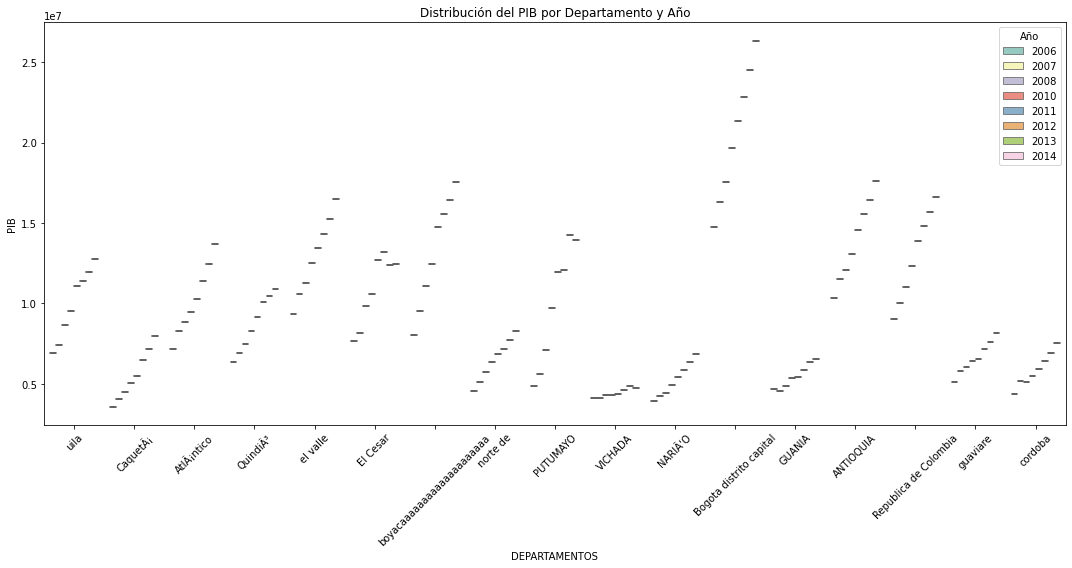

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pdf_pibcopia = pibcopia.toPandas()
pdf_pibcopia = pdf_pibcopia.drop(columns=["CÃ³digo Departamento (DIVIPOLA)"])

# Transformar el DataFrame para que sea "largo"
df_melted = pdf_pibcopia.melt(id_vars=["DEPARTAMENTOS"], 
                    var_name="Año", 
                    value_name="PIB")

# Crear el boxplot usando seaborn
plt.figure(figsize=(15,8))
sns.boxplot(x="DEPARTAMENTOS", y="PIB", hue="Año", data=df_melted, palette="Set3")
plt.title('Distribución del PIB por Departamento y Año')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dada la siguiente informacion se lobra observar que hay un crecimiento del PIB a lo largo de los años. Bogota es uno de los municipios que mas a aumentado este valor.

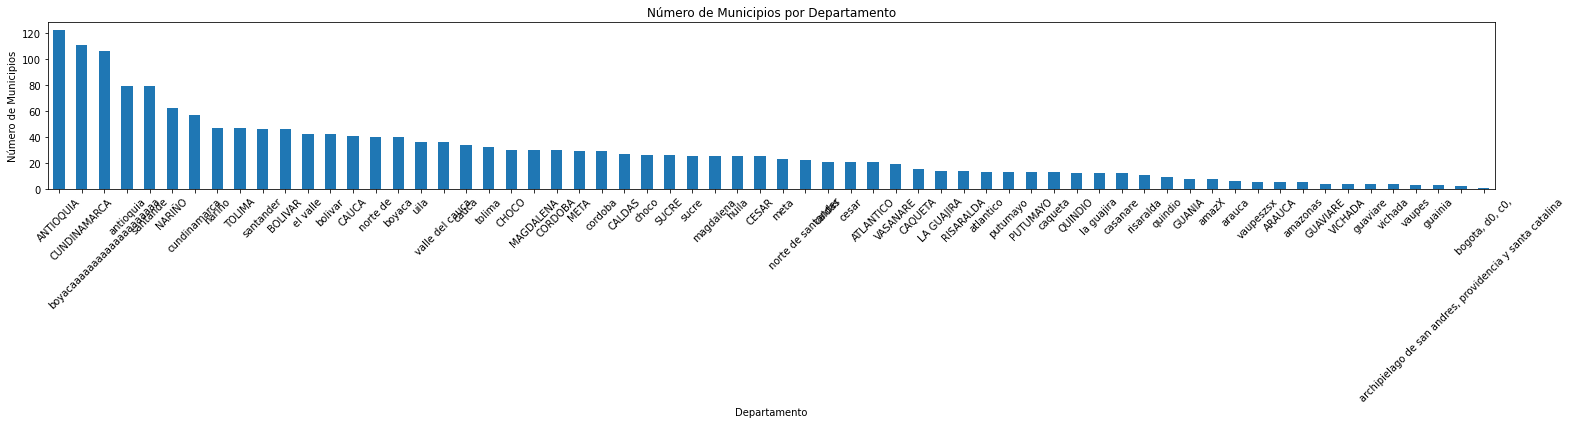

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

aggregated = (divipolacopia.groupBy("Nombre Departamento")
              .agg(f.countDistinct("Código Municipio").alias("Num_Municipios"))
              .orderBy(f.desc("Num_Municipios")))
pdf = aggregated.toPandas()
# Graficar
pdf.plot(kind='bar', x='Nombre Departamento', y='Num_Municipios', figsize=(22, 6), legend=False)
plt.title('Número de Municipios por Departamento')
plt.ylabel('Número de Municipios')
plt.xlabel('Departamento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dada la siguiente grafica podemos observar la cantidad de municipios asociados a un departamento. Como podemos observar esta informacion es muy variable debido a que los nombres de los departamentos no estan unificados y establecidos, lo cual debe ser un problema para preguntarle al cliente.

In [46]:
for column in pibcopia.columns:
    print(f"Moda para la columna {column}:")
    pibcopia.groupby(column).count().orderBy("count", ascending=False).show(5) 

Moda para la columna CÃ³digo Departamento (DIVIPOLA):
+-------------------------------+-----+
|CÃ³digo Departamento (DIVIPOLA)|count|
+-------------------------------+-----+
|                             41|    2|
|                             23|    2|
|                              8|    2|
|                             76|    2|
|                             18|    2|
+-------------------------------+-----+
only showing top 5 rows

Moda para la columna DEPARTAMENTOS:
+-------------+-----+
|DEPARTAMENTOS|count|
+-------------+-----+
|     CaquetÃ¡|    2|
|   AtlÃ¡ntico|    2|
|      VICHADA|    2|
|     guaviare|    2|
|      cordoba|    2|
+-------------+-----+
only showing top 5 rows

Moda para la columna 2006:
+-------+-----+
|   2006|count|
+-------+-----+
|4362011|    2|
|4883522|    2|
|8046451|    2|
|4655932|    2|
|4114080|    2|
+-------+-----+
only showing top 5 rows

Moda para la columna 2007:
+--------+-----+
|    2007|count|
+--------+-----+
| 8299825|    2|
| 5617663| 

In [47]:
for column in divipolacopia.columns:
    print(f"Moda para la columna {column}:")
    divipolacopia.groupby(column).count().orderBy("count", ascending=False).show(5) 

Moda para la columna Código Departamento:
+-------------------+-----+
|Código Departamento|count|
+-------------------+-----+
|                 41| 9508|
+-------------------+-----+

Moda para la columna Código Municipio:
+----------------+-----+
|Código Municipio|count|
+----------------+-----+
|           52835|  169|
|           76109|  112|
|           66001|   93|
|           23001|   75|
|           76001|   61|
+----------------+-----+
only showing top 5 rows

Moda para la columna Código Centro Poblado:
+---------------------+-----+
|Código Centro Poblado|count|
+---------------------+-----+
|             54720005|    2|
|             19807007|    2|
|             44098001|    2|
|             76275019|    2|
|             44001005|    2|
+---------------------+-----+
only showing top 5 rows

Moda para la columna Nombre Departamento:
+-------------------+-----+
|Nombre Departamento|count|
+-------------------+-----+
|          ANTIOQUIA|  734|
|           el valle|  531|
|      

En la siguiente sentencia se logra obtener la moda de cada columna de la tabla de movimientos junto con el top 5 de los valores mas frecuentes. Esto para ambas tablas (divipolacopia, y pibcopia) En donde podemos observar que la mayoria de municipios estan asociados a un departamento (antioquia).

### Análisis de calidad de datos

2.1 Completitud: Datos que no existen o no se conocen

In [48]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        df_temp = df.withColumn(c, df[c].cast("string"))        
        vacios = df_temp.filter((df_temp[c].isNull()) | (df_temp[c] == "")).count()
        if vacios != 0:
            print('Número de vacíos para columna ' + c + ': ' + str(vacios))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [50]:
print('pibcopia: ')
columnas_vacias_pibcopia = contar_vacios(pibcopia)
print(str(columnas_vacias_pibcopia))

pibcopia: 
[]


Como podemos observar para el dataframe de pibcopia no cuenta con datos vacios

In [51]:
print('divipolacopia: ')
columnas_vacias_divipolacopia = contar_vacios(divipolacopia)
print(str(columnas_vacias_divipolacopia))

divipolacopia: 
Número de vacíos para columna Nombre Distrito: 9134
Número de vacíos para columna Nombre Área Metropolitana: 9028
[9134, 9028]


Como podemos observar para el dataframe de divipolacopia cuenta con valores vacios en las columnas de Nombre Distrito (9134) y Nombre Área Metropolitana (9028)

In [52]:
columnas_alta_cardinalidad_pibcopia = cardinalidad(pibcopia)
print(columnas_alta_cardinalidad_pibcopia)

{'CÃ³digo Departamento (DIVIPOLA)': 17, 'DEPARTAMENTOS': 17, '2006': 17, '2007': 17, '2008': 17, '2010': 17, '2011': 17, '2012': 17, '2013': 17, '2014': 17}


In [53]:
columnas_alta_cardinalidad_divipolacopia = cardinalidad(divipolacopia)
print(columnas_alta_cardinalidad_divipolacopia)

{'Código Centro Poblado': 7879, 'Nombre Centro Poblado': 5512, 'Longitud': 7078, 'Latitud': 7079}


Como podemos observar para las ordenes las columnas ProveedorID tiene 197182 vacios, OrdenDeCompraID: 197182.

Respecto a cardinalidad, varias columnas tienen una cardinalidad superior al 50%.

2.2 Unicidad: Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir

In [54]:
def revisar_unicidad(df, columnas_unicas=[]):
    resultado = {}
    for columna in columnas_unicas:
        duplicados = df.groupBy(columna).count().filter(functions.col('count') > 1).count()
        if duplicados > 0:
            resultado[columna] = duplicados
    print('columnas especificas')
    print(str(resultado))

    for columna in df.columns:
        if columna not in columnas_unicas:
            duplicados = df.groupBy(columna).count().filter(functions.col('count') > 1).count()
            if duplicados > 0:
                resultado[columna] = duplicados
    print('todas las columnas')
    print(str(resultado))
    return resultado

In [56]:
columnas_sin_duplicados_pibcopia = ["CÃ³digo Departamento (DIVIPOLA)", "DEPARTAMENTOS"] 
resultado = revisar_unicidad(pibcopia, columnas_sin_duplicados_pibcopia)

columnas especificas
{'CÃ³digo Departamento (DIVIPOLA)': 10, 'DEPARTAMENTOS': 10}
todas las columnas
{'CÃ³digo Departamento (DIVIPOLA)': 10, 'DEPARTAMENTOS': 10, '2006': 10, '2007': 10, '2008': 10, '2010': 10, '2011': 10, '2012': 10, '2013': 10, '2014': 10}


Ya que se necesitaba revisar la unicidad, a traves de la ejecución de la siguiente funcion, podemos obtener las columnas que tienen duplicados junto con su cantidad (tanto especificas como todas de el dataframe)
Y para este caso encontramos que para dos de las columnas especificas tienen los siguientes valores duplicados:
- 'CÃ³digo Departamento (DIVIPOLA)': 10
- 'DEPARTAMENTOS': 10

In [57]:
columnas_sin_duplicados_divipolacopia = ["Código Centro Poblado", "Nombre Centro Poblado"] 
resultado = revisar_unicidad(divipolacopia, columnas_sin_duplicados_divipolacopia)

columnas especificas
{'Código Centro Poblado': 1629, 'Nombre Centro Poblado': 1860}
todas las columnas
{'Código Centro Poblado': 1629, 'Nombre Centro Poblado': 1860, 'Código Departamento': 1, 'Código Municipio': 969, 'Nombre Departamento': 64, 'Nombre Municipio': 1, 'Tipo Centro Poblado': 2, 'Longitud': 49, 'Latitud': 50, 'Nombre Distrito': 9, 'Municipio/Áreas No Municipalizadas (ANM)': 3, 'Nombre Área Metropolitana': 7}


Ya que se necesitaba revisar la unicidad, a traves de la ejecución de la siguiente funcion, podemos obtener las columnas que tienen duplicados junto con su cantidad (tanto especificas como todas de el dataframe)
Y para este caso encontramos que para dos de las columnas especificas tienen los siguientes valores duplicados:
- 'Código Centro Poblado': 1629
- 'Nombre Centro Poblado': 1860

2.3 Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.

In [60]:
#Caracteres no validos
invalid_chars_df = pibcopia.filter(~col("DEPARTAMENTOS").rlike("^[\\p{ASCII}]*$"))
count_invalid = invalid_chars_df.count()
print(f"Número de filas con caracteres no válidos en la columna 'DEPARTAMENTOS': {count_invalid}")

# Repeticion Excesiva
pattern = r"(.)\1{3,}"
repeated_chars_df = pibcopia.filter(col("DEPARTAMENTOS").rlike(pattern))
count_repeated = repeated_chars_df.count()
print(f"Número de filas con repetición excesiva de caracteres en 'DEPARTAMENTOS': {count_repeated}")

Número de filas con caracteres no válidos en la columna 'DEPARTAMENTOS': 6
Número de filas con repetición excesiva de caracteres en 'DEPARTAMENTOS': 2


Para poder medir la consistencia de los datos podemos evaluar los siguientes puntos:
- Caracteres no validos
- Repeticion de letras excesiva

Despues de evaluar se encontro que:
- Hay 6 departamentos con caracteres no validos.
- Hay 2 departamentos con repetición excesiva de caracteres.

2.4 Validez: Datos correctos en el contexto completitud del analisis de la calidad de datos

In [67]:
from pyspark.sql.functions import col, count, when, isnan

#Valores nulos
null_count = pibcopia.filter(col("DEPARTAMENTOS").isNull()).count()
print(f"Número de valores nulos en DEPARTAMENTOS: {null_count}")

# Valores fuera de rango para la latitud y longitud
out_of_range_lat = divipolacopia.filter((col("Latitud") < -90) | (col("Latitud") > 90)).count()
out_of_range_long = divipolacopia.filter((col("Longitud") < -180) | (col("Longitud") > 180)).count()

print(f"Número de valores fuera de rango para Latitud: {out_of_range_lat}")
print(f"Número de valores fuera de rango para Longitud: {out_of_range_long}")

# Asegurarse de consistencia de relacion de datos
missing_departments = pibcopia.join(divipolacopia, pibcopia["CÃ³digo Departamento (DIVIPOLA)"] == divipolacopia["Código Departamento"], how="left_anti")
print(f"Códigos de departamento en PIBCopia que no están en divipolacopia: {missing_departments.count()}")

Número de valores nulos en DEPARTAMENTOS: 0
Número de valores fuera de rango para Latitud: 0
Número de valores fuera de rango para Longitud: 0
Códigos de departamento en PIBCopia que no están en divipolacopia: 25


In [45]:
from pyspark.sql.functions import col, count

ids_producto_invalidos = movimientos.filter((col('ProductoID') < 1)).count()
if ids_producto_invalidos > 0:
    print(f"Hay {ids_producto_invalidos} IDs de producto fuera de rango!")

cantidades_invalidas = movimientos.filter((col('Cantidad') < 0)).count() 
if cantidades_invalidas > 0:
    print(f"Hay {cantidades_invalidas} cantidades inválidas!")

Hay 197158 cantidades inválidas!


Para esta parte se logro realizar la validez de los datos revisando:
- Valores nulos
- Valores fuera de rango para la latitud y longitud
- Asegurarse de consistencia de relacion de datos

Y a partir de los resultados se encontro:
- Hay 25 codigos de departamento de PIBCopia que no esta en divipolacopia lo cual nos indica que hacen falta datos.

### Conclusiones

#### Conclusiones generales

- pibcopia: El conjunto de datos proporciona una visión del crecimiento económico de varios departamentos de Colombia a lo largo de un período de tiempo, con una tendencia ascendente en el PIB.
- divipolacopia: El conjunto de datos describe centros poblados, principalmente en el departamento de ANTIOQUIA. Proporciona información detallada sobre las ubicaciones, municipios y características geográficas.

#### Conclusiones de Negocio

- Los departamentos registrados en pibcopia han experimentado un crecimiento económico sostenido, lo que indica una economía en crecimiento para estos departamentos durante los años registrados.
- El departamento de ANTIOQUIA, según divipolacopia, es una región con muchos centros poblados. Estos centros poblados pueden tener diferentes necesidades y oportunidades de inversión o desarrollo.


#### Conclusiones de Calidad

- Hay inconsistencias en los nombres de los departamentos y posiblemente en los códigos. Por ejemplo, "uila" debería ser "Huila".
- En divipolacopia, hay posibles problemas con los datos en minúsculas y nombres de municipios o centros poblados que pueden no ser precisos o estar mal escritos.
- La falta de datos para ciertos años y departamentos en pibcopia indica que se necesita una recolección de datos más consistente o que se verifiquen las fuentes de datos.

3.1 Justificación de si es posible resolver los análisis basados en tableros de contros propuestos.

- Histogramas/Gráficos de Barras: nos permitio entender la distribución de datos relacionados con la cantidad de centros poblados por municipio.
- Gráficos de Tiempo: nos permitio entender las tendencias en el PIB a lo largo del tiempo, proporcionando información sobre el crecimiento económico.

3.2 Incluir la síntesis de lo que representa la fila promedio de los datos analizados

pibcopia:

- PIB: El crecimiento del PIB a lo largo de los años indica una tendencia positiva. En 2006, el PIB promedio de un departamento es de aproximadamente 6,413,240, y este valor ha aumentado considerablemente hasta 2014, donde llega a un promedio de aproximadamente 11,774,719,888. Esto refleja un crecimiento económico generalizado para los departamentos representados.
- Alerta: Es esencial notar que, aunque hay registros desde 2006 hasta 2014, faltan datos para algunos años y departamentos. Es crucial solicitar estos datos faltantes para obtener una imagen más completa del crecimiento económico.

divipolacopia:

- Códigos: En promedio, se observa un código de municipio cercano a 40581. Sin embargo, al igual que el código de departamento, este número actúa como un identificador y no tiene una interpretación inherente más allá de eso.
- Alerta: Algunas columnas, como el Nombre del Distrito y el Nombre del Área Metropolitana, parecen tener muchos valores faltantes. Es esencial verificar si estos datos son relevantes y, de ser así, solicitar su inclusión. Si no son necesarios, se pueden considerar para la eliminación para optimizar el espacio y la eficiencia del análisis.

Observaciones Generales:

- Hay indicaciones claras de datos faltantes o posiblemente erróneos en ambas tablas, como los nombres de los departamentos con caracteres extraños o no estándar y valores faltantes en ciertas columnas. Es fundamental abordar estos problemas con la organización para asegurar la precisión y confiabilidad de los análisis futuros.

3.3 Lista de preguntas o comentarios realizados a la organización

1. ¿Por qué hay datos faltantes para ciertos años y departamentos en el conjunto de datos pibcopia?
2. ¿Puede proporcionarse una clarificación sobre las inconsistencias observadas en los nombres de los departamentos y municipios?
3. ¿Hay alguna razón específica por la que todos los registros en divipolacopia pertenecen al departamento de ANTIOQUIA? ¿Faltan datos de otros departamentos?
4. ¿Existe alguna otra fuente de datos que pueda ayudar a verificar o complementar la información proporcionada en estos conjuntos de datos?